# Introduction to LangGraph

In this tutorial, we'll build a customer support chatbot. We'll start with a simple model and gradually add more functionality, introducing key LangGraph concepts along the way. By the end, you will have built a chat bot that can:

- Answer common questions by searching a knowledge base
- Route complex queries to a human agent for review
- Maintain conversation state across sessions

Through the process, we will learn key LangGraph concepts like **graph** construction, nodes + edges, human-in-the-loop workflows, memory checkpointing, and more!

## Setup

First, install the required packages:

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain langchain_anthropic

Next, set your API keys:

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

(Encouraged) [LangSmith](https://smith.langchain.com/) makes it a lot easier to see what's going on "under the hood."

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**Notice** that we've initialized our `graph_builder` with a `State`. The `State` tells the graph two things:

1. Every `node` will receive the current `State` as input and return a value that updates the state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt `add_messages` function in the `Annotated` syntax.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [ ]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-haiku-20240307")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** that our chatbot node receives an instance of the `State` defined above. It returns an update to the `messages` key.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [ ]:
graph_builder.set_entry_point("chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [ ]:
graph_builder.set_finish_point("chatbot")

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [ ]:
graph = graph_builder.compile()

Now let's run the chatbot!

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

**Notice** that our chat bot lacks access to any up-to-date information to help answer questions. It also lacks memory. Fear not! We will add this all below :)

**Congrats!** You've built a simple chatbot using LangGraph. This "graph" has a single `node` with no real edges.

You can visualize the graph using the `get_graph` and one of the `draw_ascii` or `draw_png` methods (though `draw_png` comes with some other dependencies).

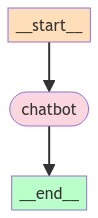

In [75]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Below is the full code for this section for your reference:

In [73]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

## Part 2: Enhancing the Chatbot with Tools

Our simple chatbot above can engage in conversation, but it may encounter questions that require up-to-date information to helpfully respond. This is where tools come in. Tools are sany function you define that allow our chatbot to take actions and access external knowledge sources, such as databases or search engines.

In this section, we'll enhance our chatbot with a web search tool. When the chatbot receives a question it can't answer with its current knowledge, it can query a search engine and use the results to formulate a response. This will make our chatbot more versatile and able to handle a wider range of user queries.

We'll use the Tavily Search in this example. When building your own chat bot, you can include your own retriever.

#### Requirements

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python

In [ ]:
_set_env("TAVILY_API_KEY")

Next, define the tool:

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

The results are page summaries our chat bot can use to answer questions.


Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [74]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Now we'll add the tools to a new node. The `ToolNode` is a helper class in LangGraph that `invoke`'s the selected tools whenever the LLM responds with 1 or more tool calls. It relies on `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

In [ ]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)

With the tool node added, we can define the `conditional_edges`. 

**Conditional edges** are functions that contain "if" statements that return the next node or nodes to execute. The functions are provided the current graph state and return a string or list of strings depending on what node to call next.

Below, call `add_conditional_edges` to route from the `chatbot` node to either the `action` or "end" using the prebuilt `tools_condition` function. Then create an edge from  the action/tools node _back to_ the chat bot to let it observe the response from our search engine and decide whether it has enough information to answer the user's question.

In [ ]:
from langgraph.prebuilt import tools_condition

# The `tools_condition` function returns "action" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "action",
    # You can update the value of the dictionary to something else
    # e.g., "action": "my_tools"
    {"action": "action", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

**Notice** that conditional edges start from a single node. This tells the graph "any time 'chatbot' runs, either go to 'action' if it calls a tool, or end the loop if it responds directly. 

Since the prebuilt `tools_condition` returns the "`__end__`" string if no tool calls are made, we don't have to explicitly set the `finish_point` this time (our graph already has a way to finish).

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

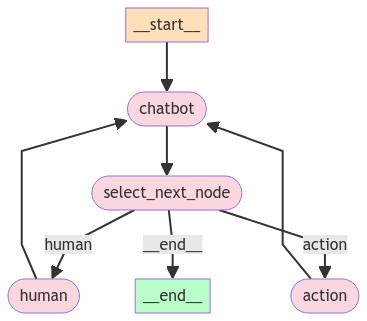

In [109]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions about current information.

In [ ]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

**Congrats!** You've created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed.

The full code for the graph we've created in this section is reproduced below:

In [ ]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"action": "action", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem by allowing you to persist the full graph state for each step in the graph's execution. This is done through a configurable `checkpointer`. 

If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each transition. In subsequent interactions with the same `thread_id`, the saved state is loaded, allowing the chatbot to pick up where it left off. 

We will see later that **checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But we'll save that for later on in the tutorial. For now, let's focus on using checkpointing to enable multi-turn conversations.

To get started, we'll first create a `checkpointer`.

In [16]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

Notice that we've specified `:memory` as the Sqlite DB path. This is convenient for our tutorial (it saves it all in-memory), but in a real application, you would change this to an existing DB and/or use one of the other checkpointer classes.

Next define the graph. The following is all copied from Part 2.

In [17]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"action": "action", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")

Finally, compile the graph with the provided checkpointer.

In [18]:
graph = graph_builder.compile(checkpointer=memory)

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [19]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [20]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    for value in event.values():
        if isinstance(value, BaseMessage):
            print("Assistant:", value.content)

**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [21]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: Yes, I remember your name is Will. It's nice to meet you!


**Notice** that we are't the memory using an external list: it's all handled by the checkpointer!  Don't believe me? Try this using a different config.

In [23]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]}, {"configurable": {"thread_id": "2"}}
)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: I'm afraid I don't actually have the capability to remember your name. As an AI assistant, I don't have a persistent memory of individual users or their names. I respond based on the current conversation without retaining details about previous interactions. Could you please restate your request or provide more context so I can try to assist you further?


**Notice** that the **only** change we've made is to modify the `thread_id` in the config. You can inspect a graph's `state` for a given config at any time.

In [24]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='da4184e5-6f54-46ac-9ff6-e0abb6067e0c'), AIMessage(content="It's nice to meet you, Will! I'm an AI assistant created by Anthropic. I'm here to help with any questions or tasks you may have. Please let me know if there is anything I can assist you with.", response_metadata={'id': 'msg_01QW6mTodtPNV68zpK3USpzu', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 375, 'output_tokens': 51}}, id='run-f89d85bc-17db-44e7-a239-8c2a383f0452-0'), HumanMessage(content='Remember my name?', id='ecee737f-76e6-4d6d-b7c1-f77e669c4bbd'), AIMessage(content="Yes, I remember your name is Will. It's nice to meet you!", response_metadata={'id': 'msg_01RUWVuULio9mTbjJqRuzqGy', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 433, 'output_tokens': 19}}, id='run-8df655aa-0e38-47fa-87a7-c7f7b1262e79-0'

In [26]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

**Congrats!** You've successfully added a **persistant checkpointer** to your graph. This lets you save each step of execution so you can handle **multi-turn conversations**. It also makes your AI applications more robust, since they can recover from and resume any time an error occurs. This is helpful for long-running operations and also opens the door to more powerful human-in-the-loop workflows (up next) and time-travel debugging and exploration (later). 

LangGraph's checkpointing is done for graph as a whole and can handle **arbitrary states**, meaning it is much more powerful than simple ChatMessageHistory.

This section's code is repeated below for you to copy.

In [ ]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"action": "action", "__end__": "__end__"},
)
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

First, start from our existing code. The following is copied from Part 3.

In [34]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

memory = SqliteSaver.from_conn_string(":memory:")


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"action": "action", "__end__": "__end__"},
)
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")

Now, compile the graph, specifying to `interrupt_before` the `action` node.

In [35]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["action"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["action"]
)

In [36]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{'text': 'Okay, let me do some more in-depth research on LangGraph for you.', 'type': 'text'}, {'id': 'toolu_01YWBi2paSf5jDF1wKHfeaVW', 'input': {'query': 'what is langGraph library'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]


Let's inspect the graph state to confirm it worked.

In [37]:
snapshot = graph.get_state(config)
snapshot.next

('action',)

**Notice** that unlike last time, the "next" node is set to **'action'**. We've interrupted here! Let's check the tool invocation.

In [38]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'what is langGraph library'},
  'id': 'toolu_01YWBi2paSf5jDF1wKHfeaVW'}]

This query seems reasonable. Nothing to filter here. The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [40]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{"url": "https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141", "content": "2. LangGraph is a powerful tool for building stateful, multi-actor applications with Large Language Models (LLMs). It extends the LangChain library, allowing you to coordinate multiple chains (or ..."}, {"url": "https://python.langchain.com/docs/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, built on top of (and intended to be used with) LangChain . It extends the LangChain Expression Language with the ability to coordinate multiple chains (or actors) across multiple steps of computation in a cyclic manner. It is inspired by Pregel and Apache Beam ."}]
Assistant: Based on the additional search results, here's a more detailed overview of what LangGraph is:

- LangGraph is a Python library that extends the LangChain framework, allowing developers to build more complex, stateful applications using large language m

**Congrats!** You've added an interrupt to permit a human check before any `action` is taken. This lets a human review and even update the graph state before continuing. Since we have already added a **checkpointer**, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.

But what if we the user (or operator) _does_ want to intercede in the graph execution? We will touch on that next.

Below is a copy of the code you used in this section. The only difference between this and the previous parts is the addition of the `interrupt_before` argument.

In [41]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"action": "action", "__end__": "__end__"},
)
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")

memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["action"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["action"]
)

## Part 5: Manually Updating the State

In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human `read` the state, but if they want to change they agent's course, they'll need to have `write` access.

Thankfully, LangGraph lets you **manually update state**! You can update state to control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update state below. As before, first, define your graph. We'll re-use the exact same graph as before.

In [43]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("action", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"action": "action", "__end__": "__end__"},
)
graph_builder.add_edge("action", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["action"],
    # Note: can also interrupt __after__ actions, if desired.
    # interrupt_after=["action"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{'text': 'Okay, let me do some more research on LangGraph for you.', 'type': 'text'}, {'id': 'toolu_0177fp6VDJrjsVP62BMMm5kR', 'input': {'query': 'how to use langGraph library'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]


In [48]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================

[{'text': 'Okay, let me do some more research on LangGraph for you.', 'type': 'text'}, {'id': 'toolu_0177fp6VDJrjsVP62BMMm5kR', 'input': {'query': 'how to use langGraph library'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]


So far, all of this is an exact repeat of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool? 

Let's directly provide the correct response!

In [53]:
from langchain_core.messages import AIMessage, ToolMessage

new_message = AIMessage(
    content="LangGraph is a library for building stateful, multi-actor applications with LLMs."
)

new_message.pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": [new_message]},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[AIMessage(content=[{'text': 'Okay, let me do some more research on LangGraph for you.', 'type': 'text'}, {'id': 'toolu_0177fp6VDJrjsVP62BMMm5kR', 'input': {'query': 'how to use langGraph library'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'id': 'msg_01KttStmqGq1aBU27nLLQmNQ', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 1698, 'output_tokens': 80}}, id='run-82ed92d8-3010-442a-bb87-2a23210589ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'how to use langGraph library'}, 'id': 'toolu_0177fp6VDJrjsVP62BMMm5kR'}]), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='ac2edd5f-c5c5-4ea1-b366-903f8a55d240')]


Now the graph is complete, since we've provided the final response message!

**Notice** that our new messages is _appended_ to the messages already in the state. Remember how we defined our `State`?

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

Since we used the pre-built `add_messages` to always append values to the existing list, the new messages added using `update_state` were added in the same way!

In fact, the `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last exectued, but you can also manually specify it below. Let's add an update that is meant to come from the "chatbot".

In [56]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'thread_ts': '2024-04-17T21:38:57.816482+00:00'}}

In [62]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[AIMessage(content=[{'text': 'Okay, let me do some more research on LangGraph for you.', 'type': 'text'}, {'id': 'toolu_0177fp6VDJrjsVP62BMMm5kR', 'input': {'query': 'how to use langGraph library'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'id': 'msg_01KttStmqGq1aBU27nLLQmNQ', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 1698, 'output_tokens': 80}}, id='run-82ed92d8-3010-442a-bb87-2a23210589ba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'how to use langGraph library'}, 'id': 'toolu_0177fp6VDJrjsVP62BMMm5kR'}]), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='ac2edd5f-c5c5-4ea1-b366-903f8a55d240'), AIMessage(content="I'm an AI expert!", id='991ffe4b-fefa-4793-bcc4-9a9c2db87b17')]
()


**Notice**: that we've continued to add AI messages to the state. Since we are acting as the `chatbot` and responding with an AIMessage that doesn't contain `tool_calls`, the graph knows that it has entered a finished state (`next` is empty).

#### What if you want to **overwrite** existing messages? 

We can do this by adding a message with an `id` that matches one of the messages in the existing state list. Within the `add_messages` function we used to annotate our graph's `State`, it looks at any message IDs in the state update. If the ID matches a message in the existing state, `add_messages` overwrites the existing message with the new content.

As an example, let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [68]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{'text': 'Okay, let me do some more in-depth research on LangGraph for you.', 'type': 'text'}, {'id': 'toolu_01KmbJB42aWwSpHHmH64wJ2h', 'input': {'query': 'what is langGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]


**Next,** let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [69]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
{'name': 'tavily_search_results_json', 'args': {'query': 'what is langGraph'}, 'id': 'toolu_01KmbJB42aWwSpHHmH64wJ2h'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'toolu_01KmbJB42aWwSpHHmH64wJ2h'}
Message ID run-bfc26e31-2a3d-4b7b-ba4e-194aad3e9787-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'toolu_01KmbJB42aWwSpHHmH64wJ2h'}]

**Notice** that we've modified the AI's tool invocation to search for "LangGraph persistance tutorial" instead of the simple "LangGraph".

Resume the graph by streaming with an input of `None` and the existing config.

In [70]:
events = graph.stream(None, config)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{"url": "https://langchain-ai.github.io/langgraph/how-tos/human-in-the-loop/", "content": "Human-in-the-loop\u00b6 When creating LangGraph agents, it is often nice to add a human in the loop component. This can be helpful when giving them access to tools. ... from langgraph.graph import MessageGraph, END # Define a new graph workflow = MessageGraph # Define the two nodes we will cycle between workflow. add_node (\"agent\", call_model) ..."}, {"url": "https://langchain-ai.github.io/langgraph/how-tos/chat_agent_executor_with_function_calling/human-in-the-loop/", "content": "from langgraph.graph import StateGraph, END # Define a new graph workflow = StateGraph (AgentState) # Define the two nodes we will cycle between workflow. add_node (\"agent\", call_model) workflow. add_node (\"action\", call_tool) # Set the entrypoint as `agent` # This means that this node is the first one called workflow. set_entry_point (\"agent ..."}]
Assistant: Based on the additional search results, h

**Notice** that now the first result of the search engine is the value about "human-in-the-loop" workflows in particular - we were able to manually override the LLM's search here.

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the _modified_ state.

In [71]:
events = graph.stream(
    {"messages": ("user", "Guess what I'm learning about these days?")}, config
)
for event in events:
    for value in event.values():
        if isinstance(value, BaseMessage):
            print("Assistant:", value.content)

**Congratulations!** You've used `interrupt_before` and `update_state` to manually modify the state as a part of a human-in-the-loop workflow. Interruptions and state modifications let you control how the agent behaves. Combined with persistant checkpointing, it means you can `pause` an action and `resume` at any point. Your user doesn't have to be available when the graph interrupts!

The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...])` (or `interrupt_after`) if you want to explicitly pause the graph whenever it reaches a node. Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.

## Part 6: Customizing State

So far, we've relied on a simple state (it's just a list of messages!). You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. In this section, we will extend our chat bot with a new node to illustrate this.

In the examples above, we involved a human deterministically: the graph __always__ interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.

Below, define this new graph, with an updated `State`

In [111]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

Next, define a schema to show the model to let it decide to request assistance.

In [112]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

Next, define the chatbot node. The primary modification here is flip the `ask_human` flag if we see that the chat bot has invoked the `RequestAssistance` flag.

In [113]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

Next, create the graph builder and add the chatbot and tools nodes to the graph, same as before.

In [128]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("action", ToolNode(tools=[tool]))

Next, create the "human" `node`. This `node` function is mostly a placeholder in our graph that will trigger an interrupt. If the human does __not__ manually update the state during the `interrupt`, it inserts a tool message so the LLM knows the user was requested but didn't respond. This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [129]:
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Next, define the conditional logic. The `select_next_node` will route to the `human` node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

Recall that the `tools_condition` function simply checks to see if the `chatbot` has responded with any `tool_calls` in its response message. If so, it routes to the `action` node. Otherwise, it ends the graph.

In [130]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "action": "action", "__end__": "__end__"},
)

Finally, add the simple directed edges and compile the graph. These edges instruct the graph to **always** flow from node `a`->`b` whenever `a` finishes executing.

In [131]:
# The rest is the same
graph_builder.add_edge("action", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    # We interupt before 'human' here instead.
    interrupt_before=["human"],
)

If you have the visualization dependencies installed, you can see the graph structure below:

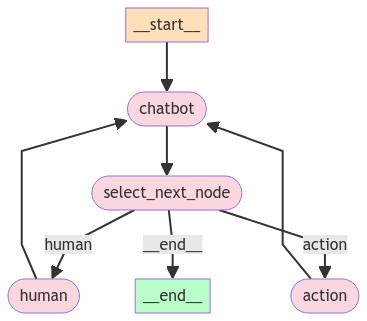

In [132]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

The chat bot can either request help from a human (chatbot->select->human), invoke the search engine tool (chatbot->select->action), or directly respond (chatbot->select->__end__). Once an action or request has been made, the graph will transition back to the `chatbot` node to continue operations.

Let's see this graph in action. We will request for expert assistance to illustrate our graph.

In [133]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{'id': 'toolu_01L3hWS9SgXRniib6KPZ8Wpi', 'input': {'request': 'I need some expert guidance for building this AI agent.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}]


**Notice:** the LLM has invoked the "`RequestAssistance`" tool we provided it, and the interrupt has been set. Let's inspect the graph state to confirm.

In [134]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

The graph state is indeed **interrupted** before the `'human'` node. We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

Next, respond to the chatbot's request by:
1. Creating a `ToolMessage` with our response. This will be passed back to the `chatbot`.
2. Calling `update_state` to manually update the graph state.

In [135]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'thread_ts': '2024-04-18T01:36:13.347820+00:00'}}

You can inspect the state to confirm our response was added.

In [136]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='bfcbc7bb-1c42-414e-b8c3-7df56e613d57'),
 AIMessage(content=[{'id': 'toolu_01L3hWS9SgXRniib6KPZ8Wpi', 'input': {'request': 'I need some expert guidance for building this AI agent.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], response_metadata={'id': 'msg_01JuYz1TvVVSGKc5v9s8RN7N', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 486, 'output_tokens': 63}}, id='run-07a89b06-7600-41bb-81fc-f23f08fe206c-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need some expert guidance for building this AI agent.'}, 'id': 'toolu_01L3hWS9SgXRniib6KPZ8Wpi'}]),
 ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.", id='db980d20-aff4-435b-8be4-9b275f7015d6', too

Next, **resume** the graph by invoking it with `None` as the inputs.

In [137]:
events = graph.stream(None, config)
for event in events:
    for value in event.values():
        if value["messages"] and isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: Based on your request, I've escalated it to our team of experts to provide guidance on building your AI agent. The experts have recommended using LangGraph, which they say is a more reliable and extensible solution compared to simple autonomous agents. Please let me know if you have any other questions - I'm happy to assist further or connect you directly with the expert team.


**Notice** that the chat bot has incorporated the updated state in its final response. Since **everything** was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

**Congratulations!** you've now added an additional node to your assistant graph to let the chat bot decide for itself whether or not it needs to interrupt execution. You did so by updating the graph `State` with a new `ask_human` field and modifying the interruption logic when compiling the graph. This lets you dynamically include a human in the loop while maintaining full **memory** every time you execute the graph.

We're almost done with the tutorial, but there is one more concept we'd like to review before finishing that connects `checkpointing` and `state updates`. 

This section's code is reproduced below for your reference.

In [138]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("action", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "action": "action", "__end__": "__end__"},
)
graph_builder.add_edge("action", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

## Part 7: Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality. 

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.

First, recall our chatbot graph. We don't need to make **any** changes from before:

In [147]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessageGraph, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("action", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "action": "action", "__end__": "__end__"},
)
graph_builder.add_edge("action", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [148]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{'text': 'Certainly, let me look into LangGraph for you:', 'type': 'text'}, {'id': 'toolu_01PeLhJCgjKjFKegvH8AN5mj', 'input': {'query': 'LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://python.langchain.com/docs/langgraph/", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, built on top of (and intended to be used with) LangChain . It extends the LangChain Expression Language with the ability to coordinate multiple chains (or actors) across multiple steps of computation in a cyclic manner. It is inspired by Pregel and Apache Beam ."}, {"url": "https://blog.langchain.dev/langgraph/", "content": "Some of the things we are looking to implement in the near future:\nIf any of these resonate with you, please feel free to add an example notebook in the LangGraph repo, or reach out to us at hello@langchain.dev for more involved collaboration!\n See this notebook for how to get started\nM

In [149]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
)
for event in events:
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{'text': "That's great that you're interested in building an autonomous agent using LangGraph! It seems like a powerful tool for creating more complex, multi-step applications with language models.\n\nA few thoughts on building an autonomous agent with LangGraph:", 'type': 'text'}, {'id': 'toolu_01Sc4kLituPFJ2FGuM8M4iBF', 'input': {'query': 'building autonomous agents with langgraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"url": "https://blog.langchain.dev/langgraph-multi-agent-workflows/", "content": "As a part of the launch, we highlighted two simple runtimes: one that is the equivalent of the AgentExecutor in langchain, and a second that was a version of that aimed at message passing and chat models.\n It's important to note that these three examples are only a few of the possible examples we could highlight - there are almost assuredly other examples out there and we look forward to seeing what the community comes up with!\n LangGraph:

Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [162]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('action',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('action',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------


**Notice** that checkpoints are saved for every step of the graph. This _spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [163]:
print(to_replay.next)
print(to_replay.config)

('action',)
{'configurable': {'thread_id': '1', 'thread_ts': '2024-04-18T01:54:15.721809+00:00'}}


**Notice** that the checkpoint's config (`to_replay.config`) contains a `thread_ts` **timestamp**. Providing this `thread_ts` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [165]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config):
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            print("Assistant:", value["messages"][-1].content)

Assistant: [{"url": "https://blog.langchain.dev/langgraph-multi-agent-workflows/", "content": "As a part of the launch, we highlighted two simple runtimes: one that is the equivalent of the AgentExecutor in langchain, and a second that was a version of that aimed at message passing and chat models.\n It's important to note that these three examples are only a few of the possible examples we could highlight - there are almost assuredly other examples out there and we look forward to seeing what the community comes up with!\n LangGraph: Multi-Agent Workflows\nLinks\nLast week we highlighted LangGraph - a new package (available in both Python and JS) to better enable creation of LLM workflows containing cycles, which are a critical component of most agent runtimes. \"\nAnother key difference between Autogen and LangGraph is that LangGraph is fully integrated into the LangChain ecosystem, meaning you take fully advantage of all the LangChain integrations and LangSmith observability.\n As p

Notice that the graph resumed execution from the `**action**` node. You can tell this is the case since the first value printed above is the response from our search engine tool.

**Congrats!** You've replayed your graph from a previous state using LangGraph's built-in "time travel" functionality. This lets your app natively branch from any previous state in its execution, enabling functionality like:

- Recovery from a previous checkpoint if a long-running process enters a failure state.
- Letting a user branch sessions off of previous one.
- Letting an agent search a possible path, update the state, and try again from a previous checkpoint.

## Conclusion

Congrats! You've completed the intro tutorial and built a chat bot in LangGraph that supports tool calling, persistent memory, human-in-the-loop interactivity, and even time-travel!

Check out some of the other examples in the LangGraph docs for more advanced use cases, and check out the how-tos for other examples on how to address frequently asked questions.